# Pricing Fixed-Income Assets

## Introduction

We seek to price a fixed-income asset knowing the distributions describing the relevant interest rates. The cash flows $c_t$ of the asset and the dates at which they occur are known. The total value $V$ of the asset is thus the expectation value of:

$$V = \sum_{t=1}^T \frac{c_t}{(1+r_t)^t}$$

Each cash flow is treated as a zero coupon bond with a corresponding interest rate $r_t$ that depends on its maturity. The user must specify the distribution modeling the uncertainty in each $r_t$ (possibly correlated) as well as the number of qubits he wishes to use to sample each distribution. In this example we expand the value of the asset to first order in the interest rates $r_t$. This corresponds to studying the asset in terms of its duration.
<br>
<br>
The approximation of the objective function follows the following paper:<br>
[Quantum Risk Analysis. Woerner, Egger. 2018.](https://arxiv.org/abs/1806.06893)

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import NormalDistribution

### Uncertainty Model

We construct a circuit to load a multivariate normal random distribution in $d$ dimensions into a quantum state.
The distribution is truncated to a given box $\otimes_{i=1}^d [low_i, high_i]$ and discretized using $2^{n_i}$ grid points, where $n_i$ denotes the number of qubits used for dimension $i = 1,\ldots, d$.
The unitary operator corresponding to the circuit implements the following: 
$$\big|0\rangle_{n_1}\ldots\big|0\rangle_{n_d} \mapsto \big|\psi\rangle = \sum_{i_1=0}^{2^n_-1}\ldots\sum_{i_d=0}^{2^n_-1} \sqrt{p_{i_1,...,i_d}}\big|i_1\rangle_{n_1}\ldots\big|i_d\rangle_{n_d},$$
where $p_{i_1, ..., i_d}$ denote the probabilities corresponding to the truncated and discretized distribution and where $i_j$ is mapped to the right interval $[low_j, high_j]$ using the affine map:
$$ \{0, \ldots, 2^{n_{j}}-1\} \ni i_j \mapsto \frac{high_j - low_j}{2^{n_j} - 1} * i_j + low_j \in [low_j, high_j].$$

In addition to the uncertainty model, we can also apply an affine map, e.g. resulting from a principal component analysis. The interest rates used are then given by:
$$ \vec{r} = A * \vec{x} + b,$$
where $\vec{x} \in \otimes_{i=1}^d [low_i, high_i]$ follows the given random distribution.

In [2]:
# can be used in case a principal component analysis has been done to derive the uncertainty model, ignored in this example.
A = np.eye(2)
b = np.zeros(2)

# specify the number of qubits that are used to represent the different dimenions of the uncertainty model
num_qubits = [2, 2]

# specify the lower and upper bounds for the different dimension
low = [0, 0]
high = [0.12, 0.24]
mu = [0.12, 0.24]
sigma = 0.01 * np.eye(2)

# construct corresponding distribution
bounds = list(zip(low, high))
u = NormalDistribution(num_qubits, mu, sigma, bounds)

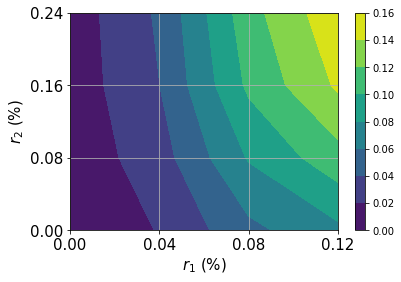

In [3]:
# plot contour of probability density function
x = np.linspace(low[0], high[0], 2 ** num_qubits[0])
y = np.linspace(low[1], high[1], 2 ** num_qubits[1])
z = u.probabilities.reshape(2 ** num_qubits[0], 2 ** num_qubits[1])
plt.contourf(x, y, z)
plt.xticks(x, size=15)
plt.yticks(y, size=15)
plt.grid()
plt.xlabel("$r_1$ (%)", size=15)
plt.ylabel("$r_2$ (%)", size=15)
plt.colorbar()
plt.show()

### Cash flow, payoff function, and exact expected value

In the following we define the cash flow per period, the resulting payoff function and evaluate the exact expected value.

For the payoff function we first use a first order approximation and then apply the same approximation technique as for the linear part of the payoff function of the [European Call Option](03_european_call_option_pricing.ipynb).

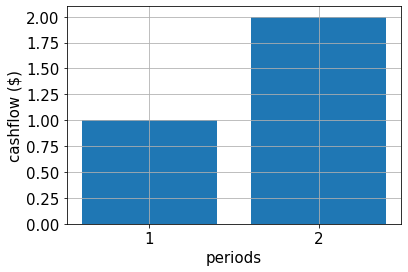

In [4]:
# specify cash flow
cf = [1.0, 2.0]
periods = range(1, len(cf) + 1)

# plot cash flow
plt.bar(periods, cf)
plt.xticks(periods, size=15)
plt.yticks(size=15)
plt.grid()
plt.xlabel("periods", size=15)
plt.ylabel("cashflow ($)", size=15)
plt.show()

In [5]:
# estimate real value
cnt = 0
exact_value = 0.0
for x1 in np.linspace(low[0], high[0], pow(2, num_qubits[0])):
    for x2 in np.linspace(low[1], high[1], pow(2, num_qubits[1])):
        prob = u.probabilities[cnt]
        for t in range(len(cf)):
            # evaluate linear approximation of real value w.r.t. interest rates
            exact_value += prob * (
                cf[t] / pow(1 + b[t], t + 1)
                - (t + 1) * cf[t] * np.dot(A[:, t], np.asarray([x1, x2])) / pow(1 + b[t], t + 2)
            )
        cnt += 1
print("Exact value:    \t%.4f" % exact_value)

Exact value:    	2.1942


In [6]:
# specify approximation factor
c_approx = 0.125

# create fixed income pricing application
from qiskit_finance.applications.estimation import FixedIncomePricing

fixed_income = FixedIncomePricing(
    num_qubits=num_qubits,
    pca_matrix=A,
    initial_interests=b,
    cash_flow=cf,
    rescaling_factor=c_approx,
    bounds=bounds,
    uncertainty_model=u,
)

In [7]:
fixed_income._objective.draw()

┌────┐
q_0: ┤0   ├
     │    │
q_1: ┤1   ├
     │    │
q_2: ┤2 F ├
     │    │
q_3: ┤3   ├
     │    │
q_4: ┤4   ├
     └────┘

In [8]:
fixed_income_circ = QuantumCircuit(fixed_income._objective.num_qubits)

# load probability distribution
fixed_income_circ.append(u, range(u.num_qubits))

# apply function
fixed_income_circ.append(fixed_income._objective, range(fixed_income._objective.num_qubits))

fixed_income_circ.draw()

┌───────┐┌────┐
q_0: ┤0      ├┤0   ├
     │       ││    │
q_1: ┤1      ├┤1   ├
     │  P(X) ││    │
q_2: ┤2      ├┤2 F ├
     │       ││    │
q_3: ┤3      ├┤3   ├
     └───────┘│    │
q_4: ─────────┤4   ├
              └────┘

In [9]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
problem = fixed_income.to_estimation_problem()

ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)

In [10]:
result = ae.estimate(problem)

In [11]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (fixed_income.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	2.1942
Estimated value:    	2.3437
Confidence interval:	[2.3101, 2.3772]


In [12]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright